In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")


In [2]:
data = pd.read_csv('HistoricalQuotes.csv')

# data = data.drop(0)  # Use only the 'Close' column
# data.rename(columns={'Close/Last': 'close'}, inplace=True)
# data.dropna(inplace=True)


In [3]:
data.columns = data.columns.str.strip()

In [4]:
dollar_col=["Close/Last","Open","High","Low"]
for col in dollar_col:
    data[col]=data[col].replace('[\$,]', '',regex=True).astype(float)

In [5]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [6]:
data.sort_values('Date',inplace=True)

In [8]:
data.rename(columns={'Close/Last': 'close'}, inplace=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2010-03-01 to 2020-02-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   2518 non-null   float64
 1   Volume  2518 non-null   int64  
 2   Open    2518 non-null   float64
 3   High    2518 non-null   float64
 4   Low     2518 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 118.0 KB


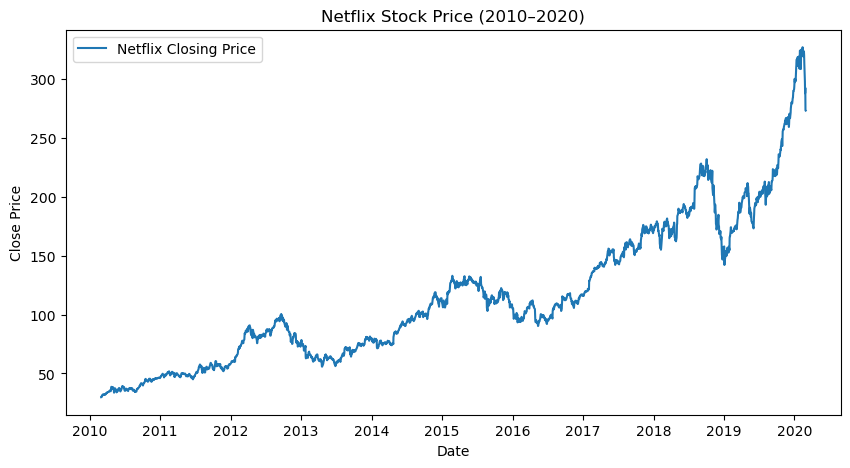

In [10]:
plt.figure(figsize=(10,5))
plt.plot(data['close'], label='Netflix Closing Price')
plt.title('Netflix Stock Price (2010–2020)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

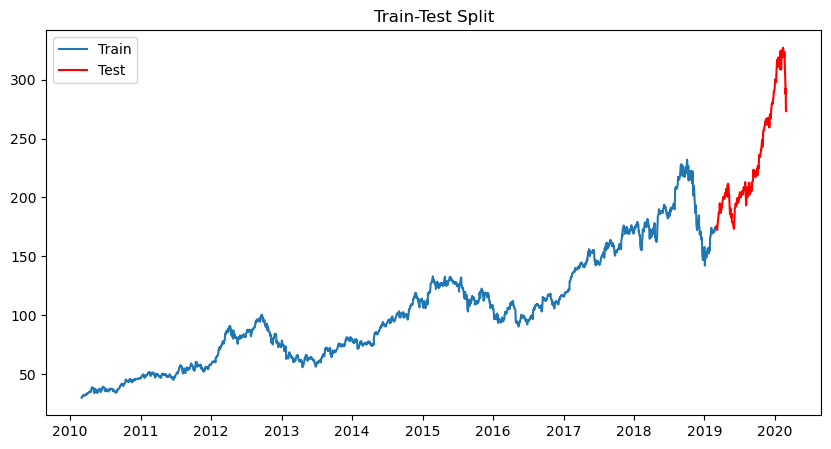

In [11]:
train_size = int(len(data) * 0.9)
train, test = data[:train_size], data[train_size:]

plt.figure(figsize=(10,5))
plt.plot(train['close'], label='Train')
plt.plot(test['close'], label='Test',color="red")
plt.title('Train-Test Split')
plt.legend()
plt.show()


Checking for stationarity

In [12]:
result = adfuller(train['close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] <= 0.05 :
    print("the data is stationary")
else:
    print("differencing is needed")




ADF Statistic: -1.0290853748765805
p-value: 0.742508840898626
differencing is needed


In [13]:
train_diff = train['close'].diff().dropna()


# Check stationarity again
result = adfuller(train_diff)
print('ADF after differencing:', result[0])
print('p-value:', result[1])

if result[1] <= 0.5:
    print("the data is stationary")
else:
    print("differencing is needed again")

ADF after differencing: -7.521840340086722
p-value: 3.7728374924495575e-11
the data is stationary


In [14]:
Train_df=pd.DataFrame(train_diff,columns=['close'])

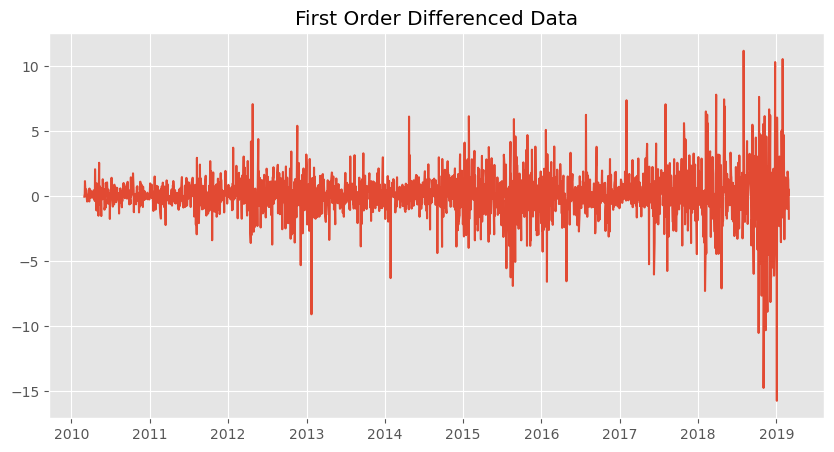

In [15]:
plt.style.use("ggplot")
plt.figure(figsize=(10,5))
plt.plot(train_diff)
plt.title('First Order Differenced Data')
plt.show()


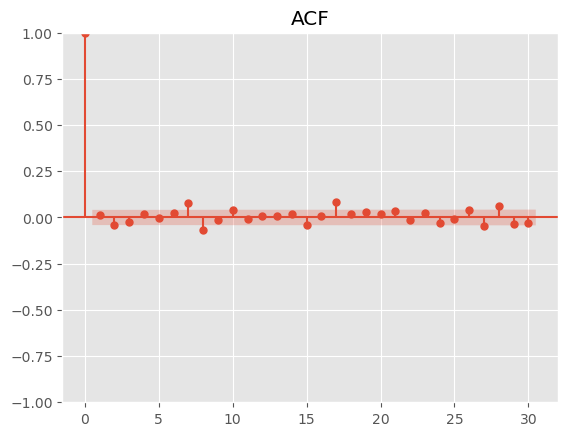

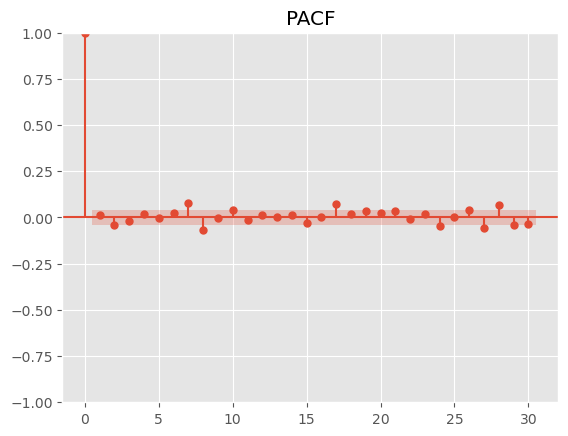

In [16]:
plot_acf(train_diff, lags=30)
# plt.figure(figsize=(9,4))
plt.title('ACF')
plt.show()

plot_pacf(train_diff, lags=30)
plt.title('PACF')
plt.show()


In [18]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
# Create lag features (supervised learning format)
def create_lag_features(series, n_lags=5):
    df = pd.DataFrame(series)
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = df['close'].shift(i)
    df.dropna(inplace=True)
    return df

df = create_lag_features(data['close'], n_lags=5)


In [19]:
# 80-20 split
split = int(len(df) * 0.8)
train, test = df.iloc[:split], df.iloc[split:]

X_train = train.drop('close', axis=1)
y_train = train['close']
X_test = test.drop('close', axis=1)
y_test = test['close']


In [20]:
X_train

,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,
2010-03-08,31.2786,30.1014,29.9043,29.8357,29.8557
2010-03-09,31.2971,31.2786,30.1014,29.9043,29.8357
2010-03-10,31.8600,31.2971,31.2786,30.1014,29.9043
2010-03-11,32.1200,31.8600,31.2971,31.2786,30.1014
2010-03-12,32.2143,32.1200,31.8600,31.2971,31.2786
...,...,...,...,...,...
2018-02-22,171.0700,171.8500,172.4300,172.9900,167.3700
2018-02-23,172.5000,171.0700,171.8500,172.4300,172.9900
2018-02-26,175.5000,172.5000,171.0700,171.8500,172.4300


In [21]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

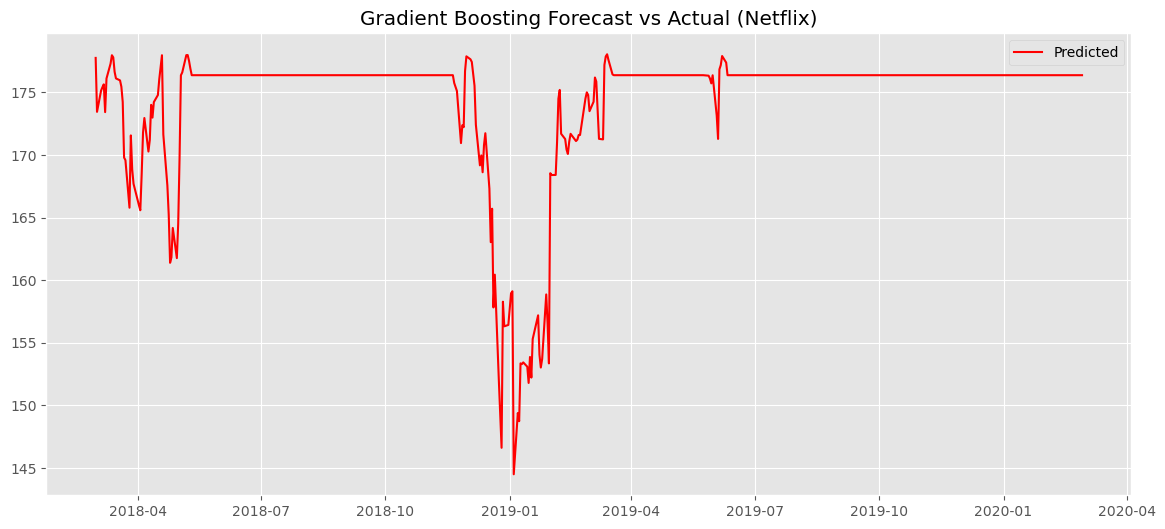

In [22]:
plt.figure(figsize=(14, 6))
# plt.plot(y_test.index, y_test, label="Actual", color='blue')
plt.plot(y_test.index, predictions, label="Predicted", color='red')
plt.title("Gradient Boosting Forecast vs Actual (Netflix)")
plt.legend()
plt.show()


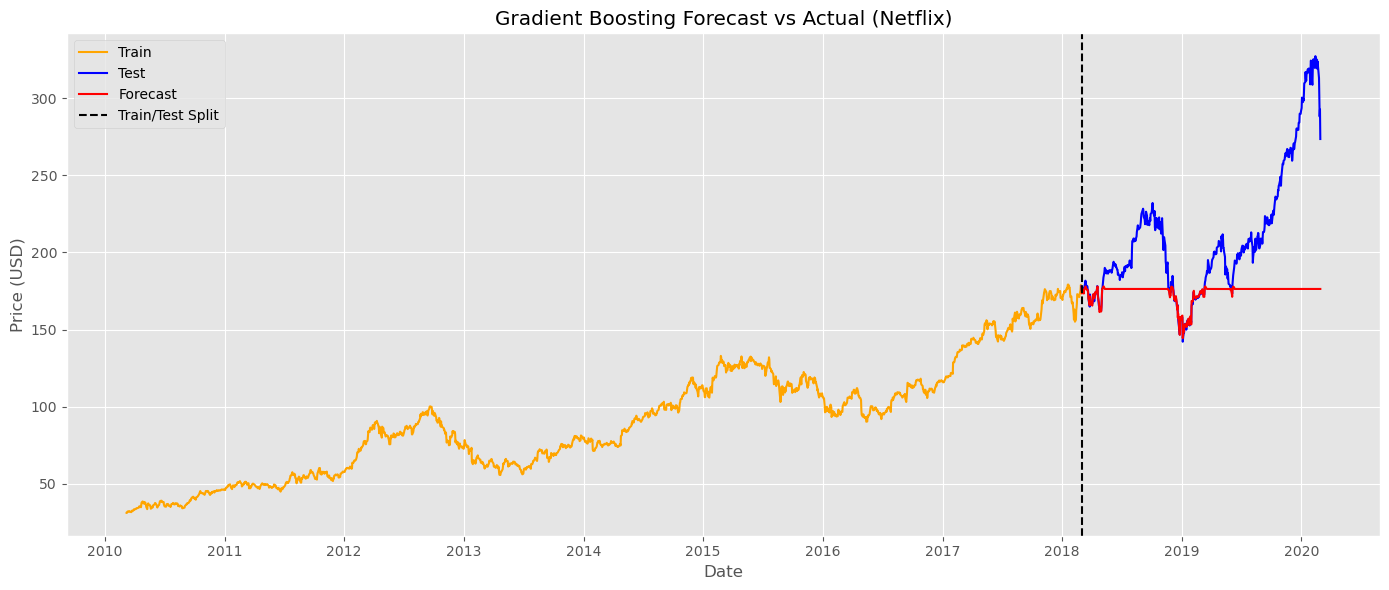

In [23]:
plt.figure(figsize=(14, 6))

# Plot the train set
plt.plot(X_train.index, X_train['lag_1'], label="Train", color="orange")

# Plot the test set (actual values)
plt.plot(X_test['lag_1'], label="Test", color="blue")

# Plot the predictions from Gradient Boosting
plt.plot(y_test.index, predictions, label="Forecast", color="red")

# Vertical line to indicate train/test split
plt.axvline(test.index[0], color='black', linestyle='--', label='Train/Test Split')

plt.title("Gradient Boosting Forecast vs Actual (Netflix)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# plt.figure(figsize=(14, 6))

# # Plot full close price
# plt.plot(df.index, df['close'], label='Actual Close Price', color='lightgray')

# # Overlay predictions on top (test portion only)
# plt.plot(y_test.index, predictions, label='Predicted (Gradient Boosting)', color='red', linewidth=2)

# plt.title("Netflix Close Price with Gradient Boosting Forecast Overlay")
# plt.xlabel("Date")
# plt.ylabel("Price (USD)")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Step 7: Plot results
# plt.figure(figsize=(14, 6))
# plt.plot(train.index, train['close'], label="Train", color="orange")
# plt.plot(test.index, test['close'], label="Test", color="blue")
# plt.plot(test.index, predictions, label="Forecast", color="red")
# plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
# plt.axvline(test.index[0], color='black', linestyle='--', label='Train/Test Split')
# plt.title("ARIMA Forecast vs Actual (Netflix)")
# plt.legend()
# plt.show()


ADF Statistic: -14.660080742389868
p-value: 3.392385417635518e-27
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7442.546, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6974.848, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=5.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7440.546, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6773.877, Time=0.64 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6643.097, Time=1.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=6577.900, Time=1.16 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=6508.906, Time=1.19 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=8.94 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=12.01 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=6506.908, Time=0.65 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=6575.902, Time=0.50 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=5.06 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=

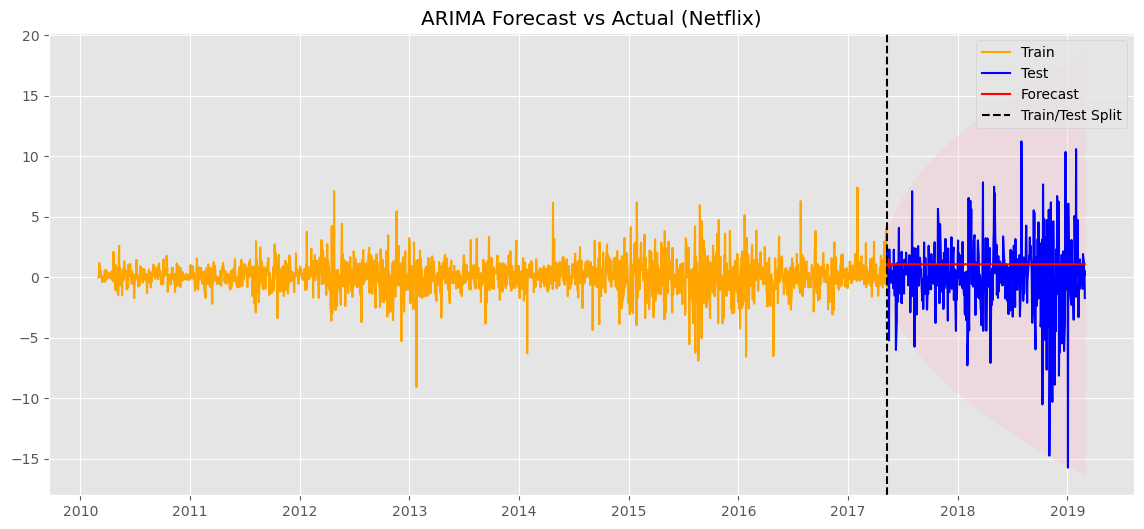

In [24]:

# Step 2: Train-test split (80-20)
split_index = int(len(Train_df) * 0.8)
train = Train_df.iloc[:split_index]
test = Train_df.iloc[split_index:]

# Step 3: Stationarity check (ADF test on differenced series)
result = adfuller(train['close'].diff().dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# Step 4: Auto ARIMA to select best (p,d,q)
stepwise_model = auto_arima(train['close'], start_p=0, start_q=0,
                            max_p=5, max_q=5, d=1,
                            seasonal=False, stepwise=True,
                            trace=True, suppress_warnings=True)

print("\nBest ARIMA order selected:", stepwise_model.order)

# Step 5: Fit final ARIMA model
model = ARIMA(train['close'], order=stepwise_model.order)
model_fit = model.fit()
print(model_fit.summary())

# Step 6: Forecasting
forecast_result = model_fit.get_forecast(steps=len(test))
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Step 7: Plot results
plt.figure(figsize=(14, 6))
plt.plot(train.index, train['close'], label="Train", color="orange")
plt.plot(test.index, test['close'], label="Test", color="blue")
plt.plot(test.index, forecast_mean, label="Forecast", color="red")
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.axvline(test.index[0], color='black', linestyle='--', label='Train/Test Split')
plt.title("ARIMA Forecast vs Actual (Netflix)")
plt.legend()
plt.show()

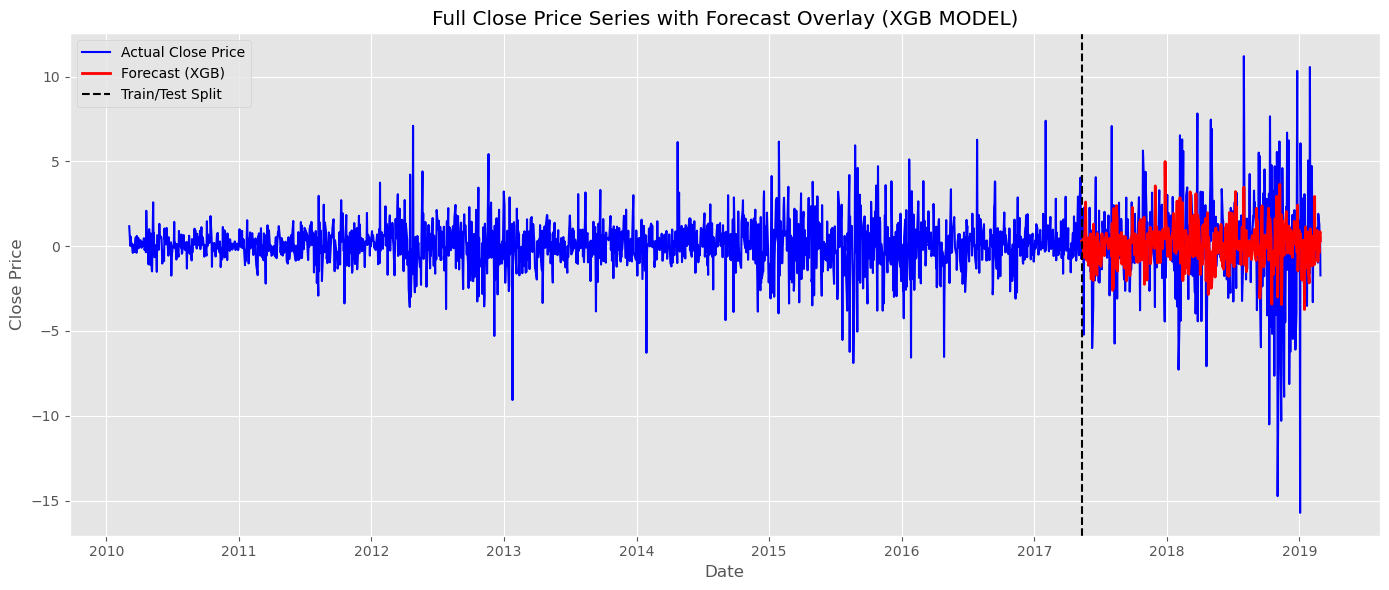

In [26]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Step 1: Create lag features
df = Train_df.copy()


df['lag1'] = df['close'].shift(1)
df['lag2'] = df['close'].shift(2)
df['lag3'] = df['close'].shift(3)
df.dropna(inplace=True)

# Step 2: Train-test split
split_index = int(len(df) * 0.8)
train = df.iloc[:split_index]
test = df.iloc[split_index:]

X_train = train[['lag1', 'lag2', 'lag3']]
y_train = train['close']
X_test = test[['lag1', 'lag2', 'lag3']]
y_test = test['close']

# Step 3: Fit Random Forest
model = XGBRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

# Step 4: Predict
predictions = model.predict(X_test)



df.loc[test.index, 'forecast'] = predictions  # Only fill test section


# Step 2: Plot everything for a big picture
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label="Actual Close Price", color="blue")
plt.plot(df.index, df['forecast'], label="Forecast (XGB)", color="red", linewidth=2)
plt.axvline(test.index[0], color='black', linestyle='--', label='Train/Test Split')
plt.title("Full Close Price Series with Forecast Overlay (XGB MODEL)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
def restore_close_and_forecast(df, close_col='close', forecast_col='forecast',
                               original_close_col='close_actual', forecast_actual_col='forecast_actual',
                               initial_close_value=None):
    """
    Reconstructs original 'close' and 'forecast' values from differenced series.

    Parameters:
    - df: DataFrame with differenced 'close' and 'forecast'.
    - close_col: Name of the differenced close column.
    - forecast_col: Name of the differenced forecast column.
    - original_close_col: Name of the output column for original close values.
    - forecast_actual_col: Name of the output column for reconstructed forecast values.
    - initial_close_value: The original close value before differencing (optional).

    Returns:
    - df: DataFrame with original close and forecast columns added.
    """
    df = df.copy()

    # Restore original close values
    diff_close = df[close_col].values

    # Set the initial value if provided, else default to 0
    if initial_close_value is None:
        initial_close_value = 0

    restored_close = [initial_close_value]
    for val in diff_close:
        restored_close.append(restored_close[-1] + val)

    # Remove the extra first item to align with df
    df[original_close_col] = restored_close[1:]

    # Restore forecast values
    forecast_start = df[forecast_col].first_valid_index()
    if forecast_start is not None:
        # Use the last known true close value before forecast
        last_known_close = df.loc[df.index[df.index.get_loc(forecast_start) - 1], original_close_col]
        forecast_diff = df.loc[forecast_start:, forecast_col].values
        restored_forecast = [last_known_close + forecast_diff[0]]
        for i in range(1, len(forecast_diff)):
            restored_forecast.append(restored_forecast[-1] + forecast_diff[i])
        df.loc[forecast_start:, forecast_actual_col] = restored_forecast

    return df


# If you know the first true close value before differencing
initial_value = 7.639999  # example value from your dataset

df = restore_close_and_forecast(df, initial_close_value=initial_value)


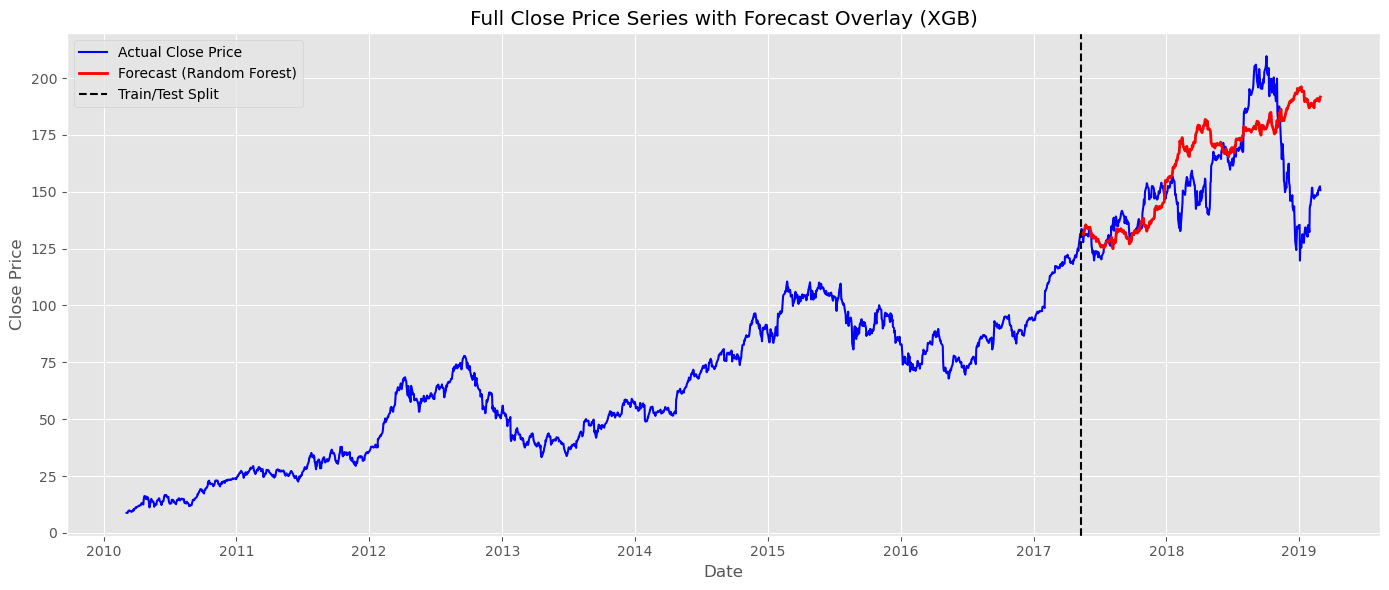

In [28]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close_actual'], label="Actual Close Price", color="blue")
plt.plot(df.index, df['forecast_actual'], label="Forecast (Random Forest)", color="red", linewidth=2)
plt.axvline(test.index[0], color='black', linestyle='--', label='Train/Test Split')
plt.title("Full Close Price Series with Forecast Overlay (XGB)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
# stepwise_model = auto_arima(train['close'], seasonal=False, trace=True)
# print(stepwise_model.summary())


from pmdarima import auto_arima

stepwise_model = auto_arima(train['close'], start_p=0, start_q=0,
                            max_p=5, max_q=5, d=1,  # or test 'd' automatically
                            seasonal=False,
                            trace=True,
                            error_action='ignore',  
                            suppress_warnings=True,
                            stepwise=True)

print(stepwise_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7432.944, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6966.098, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7430.945, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6765.441, Time=0.62 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6634.931, Time=0.81 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=6569.861, Time=1.07 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=6501.021, Time=1.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=10.00 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=9.84 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=6499.022, Time=0.61 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=6567.861, Time=0.57 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=6.10 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=5.53 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit 

In [30]:
order = stepwise_model.order
model = ARIMA(train['close'], order=order)
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1809
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3243.511
Date:                Fri, 09 May 2025   AIC                           6499.022
Time:                        17:56:56   BIC                           6532.022
Sample:                             0   HQIC                          6511.201
                               - 1809                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8089      0.017    -46.317      0.000      -0.843      -0.775
ar.L2         -0.6681      0.021    -31.440      0.000      -0.710      -0.626
ar.L3         -0.5195      0.025    -21.038      0.0

In [31]:
model = ARIMA(train['close'], order=(2,1,3))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1809
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -3106.685
Date:                Fri, 09 May 2025   AIC                           6225.371
Time:                        17:57:11   BIC                           6258.371
Sample:                             0   HQIC                          6237.550
                               - 1809                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2801      0.032    -39.712      0.000      -1.343      -1.217
ar.L2         -0.9496      0.029    -32.304      0.000      -1.007      -0.892
ma.L1          0.2969      0.031      9.565      0.0

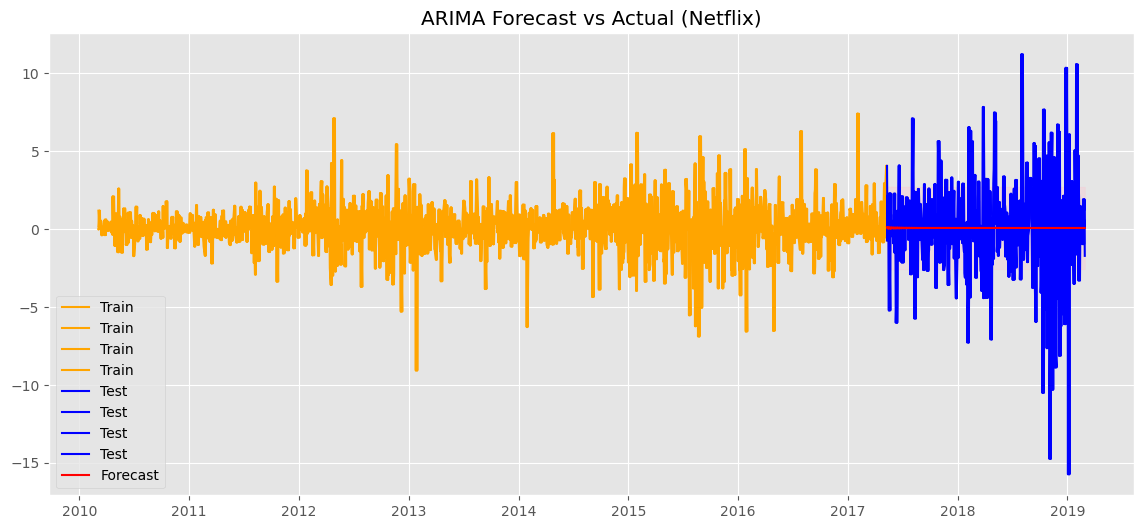

In [32]:
forecast_result = model_fit.get_forecast(steps=len(test))
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()
plt.figure(figsize=(14, 6))
plt.plot(train.index, train, label="Train", color="orange")
plt.plot(test.index, test, label="Test", color="blue")
plt.plot(test.index, forecast_mean, label="Forecast", color="red")
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("ARIMA Forecast vs Actual (Netflix)")
plt.legend()
plt.show()


In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test['close'], forecast_mean)
mae = mean_absolute_error(test['close'], forecast_mean)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")


MSE: 8.79
MAE: 2.04
